### RNA Velocity with Salmon-Alevin/scVelo

#### As mentioned in the [Rmd overview](https://github.com/trichelab/single_cell_analyses/blob/master/rnavel_alevin_scvelo.Rmd) of this analysis pipeline, this workflow primarily follows this github [page](https://combine-lab.github.io/alevin-tutorial/2020/alevin-velocity/), it proceeds along 4 main steps:

   1. Installation of pre-requisite software components <br>
   2. Downloading and indexing the genome <br>
   3. Aligning your sequencing reads to intronic and exonic regions of the genome <br>
   4. Performing the RNA Velocity calculation <br>

#### Step 1. Installation of pre-requisite software components

- Install anaconda [here](https://docs.anaconda.com/anaconda/install/), or miniconda [here](https://docs.conda.io/en/latest/miniconda.html).
- Install R ≥ v 4.0 [here](https://repo.miserver.it.umich.edu/cran/).
- If you already have R < v 4.0, run `updateR()` within the R terminal to update to the latest version.

#### Step 2. Downloading and indexing the reference genome

**A. Download reference genome and the corresponding gtf file. In this example, we are using Gencode Grch38 primary assembly** 

`wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/GRCh38.primary_assembly.genome.fa.gz` <br>
`wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.annotation.gtf.gz`

Now, it's time to open R (can be done locally or through HPC) and import (or install if you have not done so) packages required. The R script for indexing the reference and creating a linked transcriptome with tximeta is **[here](https://github.com/trichelab/single_cell_analyses/blob/master/Rscripts/step2_index_ref_genome.R)**.

**B. Preparing transcriptome indices using Salmon**

- **First of, install salmon using conda (if you have not done so)**

`conda config --add channels conda-forge`<br>
`conda config --add channels bioconda` <br> 
`conda create -n salmon salmon` <br> 
`conda activate salmon`

- **Indexing with salmon**

`grep ">" GRCh38.primary_assembly.genome.fa | cut -d ">" -f 2 | cut -d " " -f 1 > GRCh38.primary_assembly.genome.chrnames.txt`<br>
`salmon index \`<br>
`-t <(cat gencode.v34.annotation.expanded.fa GRCh38.primary_assembly.genome.fa) \`<br>
`-i gencode.v34.annotation.expanded.sidx --gencode -p 32 \`<br>
`-d GRCh38.primary_assembly.genome.chrnames.txt`

- **Now, it's time to create a linked transcriptome with tximeta (refer to the [Rscript](https://github.com/trichelab/single_cell_analyses/blob/master/Rscripts/step2_index_ref_genome.R)) **

#### Step 3. Align and quantify reads to intronic and exonic regions of the genome

**A. We will use MPAL (Mixed-Phenotype Acute Leukemia) scRNA-seq data set for this documentation from [Granja et al., 2019](https://www.nature.com/articles/s41587-019-0332-7.pdf?draft=collection). The following code downloads the bam file from SRA and uses the bamtofastq utility to convert it into a set of FASTQ files.**

`wget https://sra-pub-src-2.s3.amazonaws.com/SRR10343065/scRNA_BMMC_D1T1.bam.1` <br>
`mv scRNA_BMMC_D1T1.bam.1 scRNA_BMMC_D1T1.bam`<br>
`bamtofastq --reads-per-fastq=500000000 scRNA_BMMC_D1T1.bam FASTQtmp`<br>

**B. Run alevin to quantify the exonic and intronic abundances based on the index generated above.**
`salmon alevin -l ISR -i gencode.v34.annotation.expanded.sidx \`<br>
`-1 BMMC_D1T1_S1_L001_R1_001.fastq.gz \`<br>
`-2 BMMC_D1T1_S1_L001_R2_001.fastq.gz \`<br>
`-o alevin_out -p 36 --tgMap gencode.v34.annotation.expanded.tx2gene.tsv \`<br>
`--chromium --dumpFeatures --expectCells 1850`

**C. Import abundances into R with tximeta**

refer to the [Rscript](https://github.com/trichelab/single_cell_analyses/blob/master/Rscripts/step4_import_abundances.R)

#### Step 4. Perform RNA velocity calculation with scVelo

In [1]:
import sys

#install packages from terminal 
#e.g. 
#python -m pip install --user git+https://github.com/theislab/scvelo)
#add path, which point to where the modules are installed with 
#sys.path.append("path/to/module")

#print python path environment variable
print(sys.path) 

In [2]:
import scvelo as scv
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import leidenalg
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as pl
from matplotlib import rcParams
import louvain

In [3]:
import rpy2
import rpy2.robjects
import anndata
import anndata2ri
from rpy2.robjects import r
anndata2ri.activate()

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
scv.logging.print_version()
scv.settings.set_figure_params('scvelo')

scanpy==1.4.6 anndata==0.7.2.dev82+g2e37bb6 umap==0.4.1 numpy==1.18.1 scipy==1.3.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.7.0
Running scvelo 0.1.26.dev189+gc441c72 (python 3.6.4) on 2020-05-19 02:49.


In [4]:
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

In [5]:
%%R
sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\BMMC_D1T1_txi_alevin_abundance.rds")

In [6]:
adata = r('as(sce, "SingleCellExperiment")')
adata

AnnData object with n_obs × n_vars = 3137 × 60289
    obs: 'sizeFactor'
    uns: 'tximetaInfo', 'quantInfo', 'countsFromAbundance', 'level', 'txomeInfo', 'txdbInfo'
    obsm: 'X_pca', 'X_tsne'
    layers: 'spliced', 'unspliced', 'logcounts'

In [7]:
#show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.68 0.32]


In [8]:
#filter out genes that are lowly expressed
scv.pp.filter_genes(adata, min_shared_counts = 30)
scv.pp.normalize_per_cell(adata, enforce = True)

Filtered out 49600 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.


In [9]:
scv.pp.filter_genes_dispersion(adata, n_top_genes = 2000)
scv.pp.log1p(adata)

scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [10]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:23:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [11]:
scv.tl.velocity(adata, mode = 'dynamical')

computing velocities
    finished (0:00:17) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [12]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


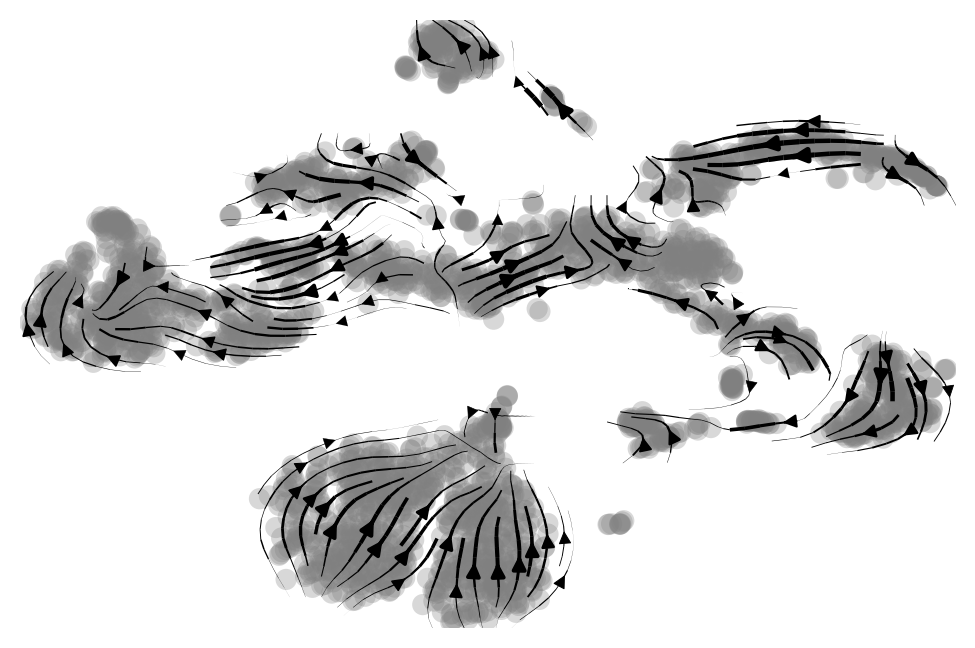

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='X_tsne')

In [14]:
adata

AnnData object with n_obs × n_vars = 3137 × 1999
    obs: 'sizeFactor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'tximetaInfo', 'quantInfo', 'countsFromAbundance', 'level', 'txomeInfo', 'txdbInfo', 'neighbors', 'recover_dynamics', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_tsne', 'velocity_tsne'
    varm: 'loss'
    layers: 'spliced', 'unspliced', 'logcounts', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'